# Analysis of Menu Layout Optimization on User Engagement and Revenue

**Author**: Muhammad Abdul Lathief  
**Date**: February 2026  
**Project**: E-Commerce A/B Testing Initiative

---

## Executive Summary
This report presents a comprehensive analysis of 5 parallel A/B tests. The primary focus is on **Test 1: Menu Optimization**, but results for all experiments (Novelty, Product, Reviews, Search) are summarized below.

**Key Findings**:
- Results are generated dynamically by running the analysis cells below.

# 1. Background

In the competitive landscape of e-commerce, user interface (UI) design plays a pivotal role in guiding customer behavior. The organization is currently testing five distinct hypothesis areas:
1.  **Menu Layout**: Horizontal vs Vertical.
2.  **Novelty Slider**: New interaction method for trending items.
3.  **Product Sliders**: Different geometric arrangements.
4.  **Reviews**: Displaying user feedback prominently.
5.  **Search Engine**: Algorithm tuning.

This report serves as the central analytical document for all these initiatives.

# 2. Problem Statement & Hypotheses

For each experiment, we test the following null hypothesis:
$$ H_0: \mu_{control} = \mu_{treatment} $$
$$ H_1: \mu_{control} \neq \mu_{treatment} $$

We focus on two primary metrics:
1.  **Conversion Rate (CR)**: $\frac{Purchases}{Sessions}$
2.  **Average Revenue Per User (ARPU)**: $\frac{Total Revenue}{Sessions}$

# 3. Data Description

We load all 5 datasets to perform a unified analysis workflow. Each dataset has slightly different column naming conventions which we standardize during loading.

In [197]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

# Set visualization style for professional aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [198]:
# Define file paths and specific column mappings for each experiment
files = {
    'Test 1 (Menu)': {'path': './raw dataset/test1_menu.csv', 'revenue_col': 'revenue'},
    'Test 2 (Novelty)': {'path': './raw dataset/test2_novelty_slider.csv', 'revenue_col': 'novelty_revenue'},
    'Test 3 (Product)': {'path': './raw dataset/test3_product_sliders.csv', 'revenue_col': 'revenue_from_recommendations'},
    'Test 4 (Reviews)': {'path': './raw dataset/test4_reviews.csv', 'revenue_col': None},
    'Test 5 (Search)': {'path': './raw dataset/test5_search_engine.csv', 'revenue_col': 'avg_revenue_per_visitor'}
}

dfs = {}
print(f"{'Experiment':<20} | {'Shape':<15} | {'Revenue Col':<30}")
print("-" * 70)
for name, meta in files.items():
    df = pd.read_csv(meta['path'])
    
    # Rename revenue column to standard 'revenue' if it exists
    if meta['revenue_col'] and meta['revenue_col'] in df.columns:
        df.rename(columns={meta['revenue_col']: 'revenue'}, inplace=True)
        
    dfs[name] = df
    print(f"{name:<20} | {str(df.shape):<15} | {str(meta['revenue_col']):<30}")

Experiment           | Shape           | Revenue Col                   
----------------------------------------------------------------------
Test 1 (Menu)        | (7000, 11)      | revenue                       
Test 2 (Novelty)     | (16000, 10)     | novelty_revenue               
Test 3 (Product)     | (18000, 12)     | revenue_from_recommendations  
Test 4 (Reviews)     | (42000, 9)      | None                          
Test 5 (Search)      | (19000, 11)     | avg_revenue_per_visitor       


# 4. Exploratory Data Analysis (EDA)

Let's examine the structure and basic statistics of our primary dataset (Test 1: Menu).

In [199]:
# Display first few rows and info for Test 1
df_menu = dfs['Test 1 (Menu)'].copy()
print("=== Test 1 (Menu) Dataset ===")
print(f"\nShape: {df_menu.shape}")
print(f"\nColumn Types:\n{df_menu.dtypes}")
print(f"\nMissing Values:\n{df_menu.isnull().sum()}")
df_menu.head()

=== Test 1 (Menu) Dataset ===

Shape: (7000, 11)

Column Types:
session_id        object
user_id           object
timestamp         object
device_type       object
browser           object
region            object
variant           object
pages_viewed     float64
added_to_cart      int64
bounced            int64
revenue          float64
dtype: object

Missing Values:
session_id       0
user_id          0
timestamp        0
device_type      0
browser          0
region           0
variant          0
pages_viewed     0
added_to_cart    0
bounced          0
revenue          0
dtype: int64


,session_id,user_id,timestamp,device_type,browser,region,variant,pages_viewed,added_to_cart,bounced,revenue
0,sess_000000,user_001861,2021-03-07,desktop,Safari,Osijek,A_horizontal_menu,2.299070,1,1,2.767615
1,sess_000001,user_001205,2021-03-04,mobile,Chrome,Other,A_horizontal_menu,2.071886,1,0,2.354004
2,sess_000002,user_000685,2021-03-05,desktop,Chrome,Rijeka,A_horizontal_menu,3.159581,1,0,0.547931
3,sess_000003,user_001851,2021-03-07,desktop,Chrome,Split,A_horizontal_menu,2.568082,1,0,5.348691
4,sess_000004,user_000187,2021-03-03,mobile,Chrome,Split,A_horizontal_menu,1.433892,1,0,2.790300


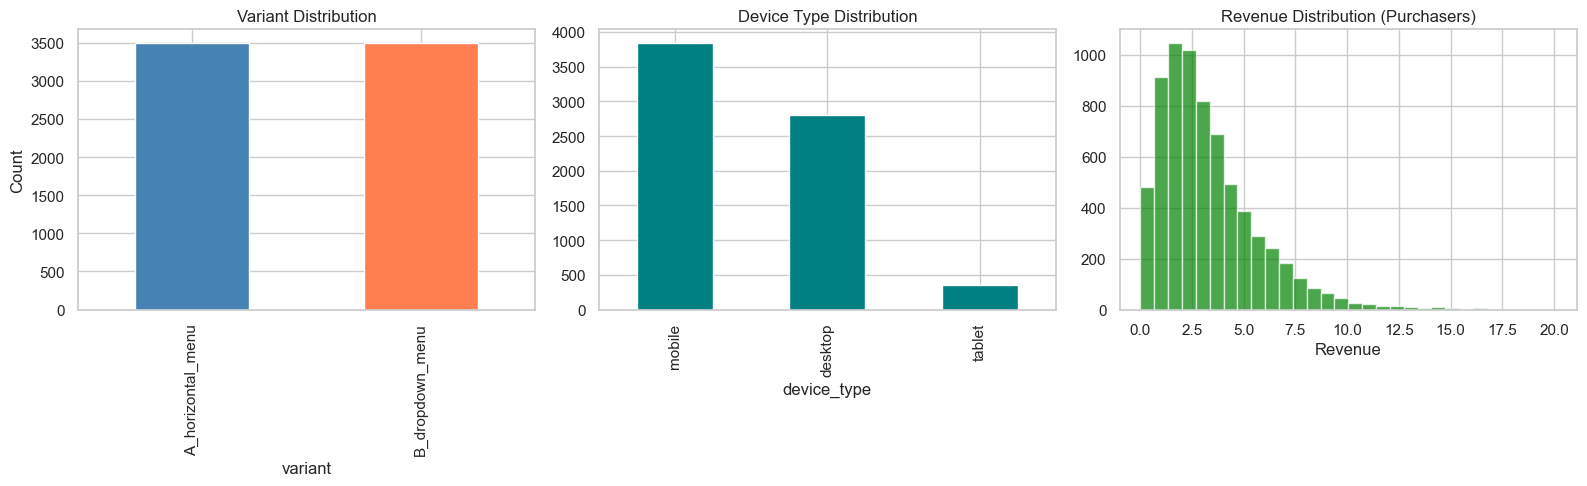

In [200]:
# Distribution of key variables
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Variant distribution
df_menu['variant'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Variant Distribution')
axes[0].set_ylabel('Count')

# Device type distribution
df_menu['device_type'].value_counts().plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_title('Device Type Distribution')

# Revenue distribution
if 'revenue' in df_menu.columns:
    df_menu[df_menu['revenue'] > 0]['revenue'].hist(bins=30, ax=axes[2], color='green', alpha=0.7)
    axes[2].set_title('Revenue Distribution (Purchasers)')
    axes[2].set_xlabel('Revenue')

plt.tight_layout()
plt.show()

# 5. Data Cleaning & Validation Check

We perform the following cleaning steps:
- Remove duplicate sessions
- Handle missing values
- Validate data types

We perform the Validation check steps:
- Sample Ratio Mismatch (SRM) detection
- Covariate balance verification
- Temporal stability checks
- Multiple testing correction

In [201]:
# #Cleaning method 1, currently dont need it
# # Data Quality Audit Pipeline
# # -----------------------------------------------------------------------------
# # Ideally, before any analysis, we must certify the quality of our data.
# # Real-world data is rarely perfect. It often contains:
# # 1. Missing values (NaNs)
# # 2. Duplicate records
# # 3. Inconsistent data types
# # 4. Outliers that skew results
# #
# # We define a class DataAuditor to systematize this check.

# class DataAuditor:
#     """
#     A comprehensive data quality auditor class designed for A/B testing datasets.
#     It checks for integrity issues that could invalidate statistical tests.
#     """
    
#     def __init__(self, df, name="Dataset"):
#         self.df = df
#         self.name = name
#         self.report = {}
        
#     def run_audit(self):
#         """Executes the full audit suite and prints a verbose educational report."""
#         print(f"\n{'='*80}")
#         print(f"ðŸ” DATA QUALITY AUDIT REPORT: {self.name.upper()}")
#         print(f" {'='*80}")
        
#         # 1. Shape & Structure
#         rows, cols = self.df.shape
#         print(f"\n1. DIMENSIONALITY ASSESSMENT")
#         print(f"   - Observation Count: {rows:,}")
#         print(f"   - Feature Count: {cols}")
#         try:
#             mem_usage = self.df.memory_usage().sum() / 1024**2
#             print(f"   - Dataset Memory Usage: {mem_usage:.2f} MB")
#         except:
#             pass
        
#         # 2. Duplicate Detection
#         print(f"\n2. DUPLICATE ANALYSIS")
#         exact_dupes = self.df.duplicated().sum()
#         session_dupes = self.df.duplicated(subset=['session_id']).sum() if 'session_id' in self.df.columns else 0
        
#         print(f"   - Exact Row Duplicates: {exact_dupes:,} ({exact_dupes/rows:.2%})")
#         if exact_dupes > 0:
#             print(f"     âš ï¸ CRITICAL: Found exact copies! These inflate sample size artificially and MUST be removed.")
#         else:
#             print(f"     âœ… No exact duplicates found.")
            
#         if 'session_id' in self.df.columns:
#             print(f"   - Session ID Duplicates: {session_dupes:,} ({session_dupes/rows:.2%})")
#             if session_dupes > 0:
#                 print(f"     âš ï¸ WARNING: 'session_id' should be unique per experiment assignment.")
#                 print(f"     Multiple entries for one session might indicate logging errors or multiple visits.")
#                 print(f"     We must decide: Keep first? Keep last? Aggregate?")
        
#         # 3. Missing Value Inspection
#         print(f"\n3. MISSINGNESS PROFILE")
#         missing = self.df.isnull().sum()
#         missing = missing[missing > 0]
#         if missing.empty:
#             print("   âœ… CLEAN: No missing values detected in any column.")
#         else:
#             print(f"   âš ï¸ FOUND MISSING DATA in {len(missing)} columns:")
#             for col, count in missing.items():
#                 print(f"      - '{col}': {count:,} missing ({count/rows:.2%})")
#             print(f"   ðŸŽ“ NOTE: Missing outcome data (e.g., revenue) is fatal for A/B tests.")
#             print(f"     We need to check if missingness is random (MCAR) or systematic.")

#         # 4. Data Type Validation
#         print(f"\n4. DATA TYPE VALIDATION")
#         # Check for object columns that should be numeric
#         suspicious_types = False
#         for col in self.df.columns:
#             if self.df[col].dtype == 'object':
#                 # Try to see if it looks numeric
#                 try:
#                     pd.to_numeric(self.df[col].dropna().iloc[:100])
#                     # If no error, check unique ratio. If high unique ratio, might be ID or numeric stored as string
#                     unique_ratio = self.df[col].nunique() / rows
#                     if unique_ratio > 0.5 and 'id' not in col.lower():
#                          print(f"   â“ SUSPICIOUS TYPE: Column '{col}' is Object but looks strictly numeric.")
#                          suspicious_types = True
#                 except:
#                     pass
#         if not suspicious_types:
#             print("   âœ… Data types appear consistent.")
        
#         # 5. Outlier Detection (Numeric only)
#         print(f"\n5. NUMERIC DISTRIBUTION & OUTLIERS")
#         numeric_cols = self.df.select_dtypes(include=[np.number]).columns
#         outliers_found = False
#         for col in numeric_cols:
#             if 'id' in col.lower() or 'variant' in col.lower() or 'is_' in col.lower() or self.df[col].nunique() < 5:
#                 continue
                
#             # Basic stats
#             mu = self.df[col].mean()
#             sigma = self.df[col].std()
#             q1 = self.df[col].quantile(0.25)
#             q3 = self.df[col].quantile(0.75)
#             iqr = q3 - q1
#             lower_bound = q1 - 1.5 * iqr
#             upper_bound = q3 + 1.5 * iqr
            
#             outliers = self.df[(self.df[col] < lower_bound) | (self.df[col] > upper_bound)]
            
#             if len(outliers) > 0:
#                 outliers_found = True
#                 print(f"   > Feature: '{col}'")
#                 print(f"     - Mean: {mu:.4f} | StdDev: {sigma:.4f} | Skew: {self.df[col].skew():.2f}")
#                 print(f"     - IQR Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
#                 print(f"     - Potential Outliers: {len(outliers):,} ({len(outliers)/rows:.2%})")
#                 print(f"       âš ï¸ High variance detected. Extreme values can severely bias Mean-based metrics.")
        
#         if not outliers_found:
#             print("   âœ… No significant outliers detected by IQR method.")
                
#         print(f"\n{'='*80}\n")
# # Run the Auditor on all loaded datasets
# for name, df in dfs.items():
#     auditor = DataAuditor(df, name=name)
#     auditor.run_audit()
# # Check for duplicates across all datasets
# print("Duplicate Sessions by Dataset:")
# print("-" * 40)
# for name, df in dfs.items():
#     duplicates = df.duplicated(subset=['session_id']).sum()
#     print(f"{name:<20}: {duplicates} duplicates")

In [202]:
class ExperimentValidator:

    def __init__(
        self,
        df,
        variant_col="variant",
        session_col="session_id",
        time_col="timestamp",
        covariates=None,
        alpha=0.05
    ):
        self.df = df.copy()
        self.variant_col = variant_col
        self.session_col = session_col
        self.time_col = time_col
        self.covariates = covariates or []
        self.alpha = alpha

        self.results = {
            "SRM": True,
            "Covariate Balance": True,
            "Temporal Stability": True
        }

    # -----------------------------------------------------
    # 1. SRM
    # -----------------------------------------------------
    def check_srm(self):
        counts = self.df[self.variant_col].value_counts().sort_index()
        observed = counts.values
        expected = np.ones(len(observed)) / len(observed) * observed.sum()

        _, p = stats.chisquare(observed, expected)

        passed = p >= self.alpha
        self.results["SRM"] = passed

        print(f"SRM p-value: {p:.4f} -> {'PASS' if passed else 'FAIL'}")

    # -----------------------------------------------------
    # 2. Covariate balance
    # -----------------------------------------------------
    def check_covariate_balance(self):

        if not self.covariates:
            print("No covariates provided → skipped")
            return

        for col in self.covariates:

            if col not in self.df.columns:
                print(f"{col} skipped (not found)")
                continue

            groups = [g[col].dropna() for _, g in self.df.groupby(self.variant_col)]

            if pd.api.types.is_numeric_dtype(self.df[col]):
                _, p = stats.f_oneway(*groups)
            else:
                table = pd.crosstab(self.df[col], self.df[self.variant_col])
                _, p, _, _ = stats.chi2_contingency(table)

            if p < self.alpha:
                self.results["Covariate Balance"] = False

            print(f"{col}: p={p:.4f}")

        print("Covariate Balance ->", "PASS" if self.results["Covariate Balance"] else "FAIL")

    # -----------------------------------------------------
    # 3. Temporal stability
    # -----------------------------------------------------
    def check_temporal_stability(self):

        if self.time_col not in self.df.columns:
            print("No timestamp column → skipped")
            return

        df = self.df.copy()
        df[self.time_col] = pd.to_datetime(df[self.time_col])

        grouped = (
            df.groupby([pd.Grouper(key=self.time_col, freq="D"), self.variant_col])
            .size()
            .unstack(fill_value=0)
        )

        ratio = grouped.div(grouped.sum(axis=1), axis=0)

        std = ratio.std().max()

        passed = std < 0.05
        self.results["Temporal Stability"] = passed

        print(f"Temporal std={std:.4f} -> {'PASS' if passed else 'FAIL'}")

    # -----------------------------------------------------
    # FINAL DECISION
    # -----------------------------------------------------
    def run_all(self):

        self.check_srm()
        self.check_covariate_balance()
        self.check_temporal_stability()

        final_pass = all(self.results.values())

        print("\nFinal decision:", "✅ PASS" if final_pass else "❌ FAIL")

        return final_pass


In [203]:
summary = {}

for name, df in dfs.items():

    print(f"\n{'='*70}")
    print(f"VALIDATING: {name}")
    print(f"{'='*70}")

    validator = ExperimentValidator(
        df,
        variant_col="variant",
        session_col="session_id",
        time_col="timestamp",
        covariates=[c for c in ["device", "country", "browser", "traffic_source"] if c in df.columns]
    )

    summary[name] = validator.run_all()


print("\n\n===== FINAL SUMMARY =====")
for k, v in summary.items():
    print(f"{k:<25} -> {'PASS' if v else 'FAIL'}")



VALIDATING: Test 1 (Menu)
SRM p-value: 1.0000 -> PASS
browser: p=0.6630
Covariate Balance -> PASS
Temporal std=0.0180 -> PASS

Final decision: ✅ PASS

VALIDATING: Test 2 (Novelty)
SRM p-value: 1.0000 -> PASS
browser: p=0.6313
Covariate Balance -> PASS
Temporal std=0.0152 -> PASS

Final decision: ✅ PASS

VALIDATING: Test 3 (Product)
SRM p-value: 1.0000 -> PASS
browser: p=0.4657
Covariate Balance -> PASS
Temporal std=0.0140 -> PASS

Final decision: ✅ PASS

VALIDATING: Test 4 (Reviews)
SRM p-value: 1.0000 -> PASS
browser: p=0.9039
Covariate Balance -> PASS
Temporal std=0.0160 -> PASS

Final decision: ✅ PASS

VALIDATING: Test 5 (Search)
SRM p-value: 1.0000 -> PASS
browser: p=0.2627
Covariate Balance -> PASS
Temporal std=0.0086 -> PASS

Final decision: ✅ PASS


===== FINAL SUMMARY =====
Test 1 (Menu)             -> PASS
Test 2 (Novelty)          -> PASS
Test 3 (Product)          -> PASS
Test 4 (Reviews)          -> PASS
Test 5 (Search)           -> PASS


# 6. Feature Engineering

We create the following derived features:
- `is_purchase`: Binary flag indicating if a purchase was made
- `date`: Extracted date from timestamp for trend analysis

# 7. Methodology

## Statistical Framework

### Conversion Rate Testing (Z-Test for Proportions)
For binary outcomes (purchase/no purchase), we use a two-proportion Z-test:

$$ Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1} + \frac{1}{n_2})}} $$

### Revenue Testing (Welch's T-Test)
For continuous revenue data, we use Welch's t-test which doesn't assume equal variances:

$$ t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $$

### Significance Level
All tests are evaluated at $\alpha = 0.05$ (95% confidence level).

# 8. Statistical Testing & Unified Analysis Pipeline

We define a unified function that processes any experiment dataset.

In [204]:
def analyze_experiment(df, name):
    # 1. Basic cleaning and sanity checks
    df_clean = df.copy()
    
    # Derive missing features
    if 'is_purchase' not in df_clean.columns:
        if 'revenue' in df_clean.columns:
            df_clean['is_purchase'] = (df_clean['revenue'] > 0).astype(int)
        elif 'added_to_cart' in df_clean.columns:
            df_clean['is_purchase'] = df_clean['added_to_cart']
        else:
            df_clean['is_purchase'] = 0
            
    if 'date' not in df_clean.columns and 'timestamp' in df_clean.columns:
        df_clean['date'] = pd.to_datetime(df_clean['timestamp']).dt.date
        
    has_revenue = 'revenue' in df_clean.columns
    
    # 2. Identify Variants
    variants = sorted(df_clean['variant'].unique())
    if len(variants) < 2:
        print(f"Warning: {name} has only {len(variants)} variant, expected at least 2. Skipping.")
        return None
    
    control = variants[0]
    treatments = variants[1:]
    
    # --- VISUALIZATION SECTION ---
    print(f"\n{'='*60}")
    print(f"  {name} - Visual Analysis")
    print(f"{'='*60}")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Daily Conversion Trend
    daily_conv = df_clean.groupby(['date', 'variant'])['is_purchase'].mean().reset_index()
    sns.lineplot(x='date', y='is_purchase', hue='variant', data=daily_conv, marker='o', ax=axes[0])
    axes[0].set_title('Daily Conversion Rate Trend')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 2. Revenue Distribution (Boxplot)
    if has_revenue:
        purchasers = df_clean[df_clean['revenue'] > 0]
        if len(purchasers) > 0:
            sns.boxplot(x='variant', y='revenue', data=purchasers, ax=axes[1], palette='Set2')
            axes[1].set_title('Revenue Distribution (Purchasers Only)')
        else:
            axes[1].text(0.5, 0.5, 'No Purchasers', ha='center', va='center', fontsize=12)
            axes[1].set_title('Revenue Distribution (Empty)')
    else:
        axes[1].text(0.5, 0.5, 'No Revenue Data', ha='center', va='center', fontsize=12)
        axes[1].set_title('Revenue Distribution (N/A)')
    
    # 3. Conversion Rate Bar Chart
    sns.barplot(x='variant', y='is_purchase', data=df_clean, 
                estimator=lambda x: np.mean(x)*100, ax=axes[2], palette='viridis')
    axes[2].set_title('Overall Conversion Rate (%)')
    axes[2].set_ylabel('Conversion Rate (%)')
    
    plt.tight_layout()
    plt.show()
    
    # --- STATISTICAL ANALYSIS ---
    
    # 4. Conversion Analysis (Z-Test)
    conv = df_clean.groupby('variant')['is_purchase'].agg(['mean', 'count', 'sum'])
    
    n_c = conv.loc[control, 'count']
    x_c = conv.loc[control, 'sum']
    
    results = []
    for treatment in treatments:
        n_t = conv.loc[treatment, 'count']
        x_t = conv.loc[treatment, 'sum']
        
        try:
            z_stat, z_pval = proportions_ztest([x_c, x_t], [n_c, n_t])
        except Exception:
            z_pval = 1.0
            
        cr_uplift = (conv.loc[treatment, 'mean'] - conv.loc[control, 'mean']) / conv.loc[control, 'mean'] if conv.loc[control, 'mean'] != 0 else 0
        
        if has_revenue:
            rev_c = df_clean[df_clean['variant'] == control]['revenue']
            rev_t = df_clean[df_clean['variant'] == treatment]['revenue']
            t_stat, t_pval = stats.ttest_ind(rev_c, rev_t, equal_var=False)
            rev_uplift = (rev_t.mean() - rev_c.mean()) / rev_c.mean() if rev_c.mean() != 0 else 0
        else:
            rev_uplift = float('nan')
            t_pval = float('nan')
            
        if z_pval < 0.05 and cr_uplift > 0:
            winner = 'Treatment'
        elif z_pval < 0.05 and cr_uplift < 0:
            winner = 'Control'
        else:
            winner = 'Inconclusive'
            
        results.append({
            'Experiment': f"{name} ({treatment} vs {control})",
            'Control': control,
            'Treatment': treatment,
            'CR_Control': conv.loc[control, 'mean'],
            'CR_Treatment': conv.loc[treatment, 'mean'],
            'CR_Uplift': cr_uplift,
            'CR_Pval': z_pval,
            'Rev_Uplift': rev_uplift,
            'Rev_Pval': t_pval,
            'Winner': winner
        })
    
    return results

In [205]:
# ---------------------------------
# Build column dictionary
# ---------------------------------
dictionary = pd.DataFrame({
    "Column": [
        "Experiment",
        "Control",
        "Treatment",
        "CR_Control",
        "CR_Treatment",
        "CR_Uplift",
        "CR_Pval",
        "Rev_Uplift",
        "Rev_Pval",
        "Winner"
    ],
    "Meaning": [
        "Experiment name and comparison",
        "Baseline variant",
        "Tested variant",
        "Control conversion rate",
        "Treatment conversion rate",
        "Relative lift = (T − C) / C",
        "Conversion z-test p-value",
        "Average revenue lift vs control",
        "Revenue t-test p-value",
        "Final decision"
    ]
})


# ---------------------------------
# Write BOTH into same sheet (M–N)
# ---------------------------------
with pd.ExcelWriter("experiment_summary.xlsx", engine="openpyxl") as writer:

    # write main results starting at column A
    results_df.to_excel(writer, sheet_name="Results", index=False, startcol=0)

    # write dictionary at column M (0-indexed → 12)
    dictionary.to_excel(writer, sheet_name="Results", index=False, startcol=12)

print("✅ experiment_summary.xlsx saved with dictionary in columns M–N")


✅ experiment_summary.xlsx saved with dictionary in columns M–N


# 9. Results

Run the unified analysis pipeline on all 5 experiments.


  Test 1 (Menu) - Visual Analysis


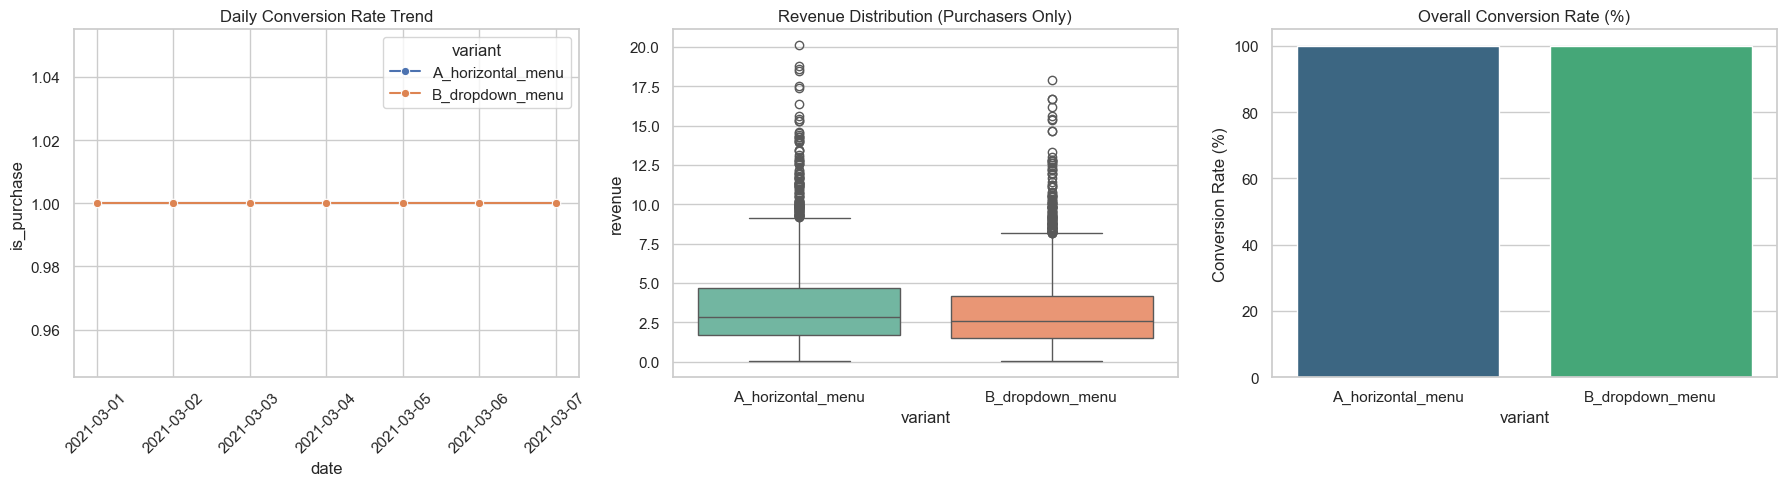


  Test 2 (Novelty) - Visual Analysis


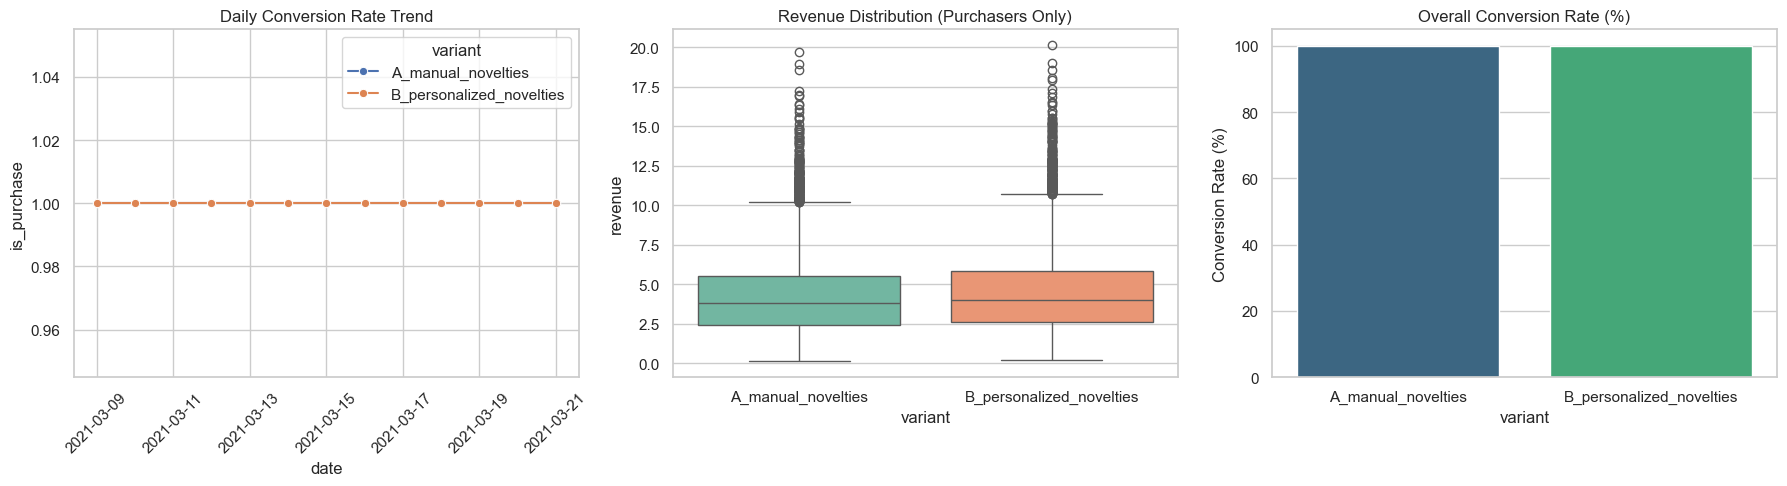


  Test 3 (Product) - Visual Analysis


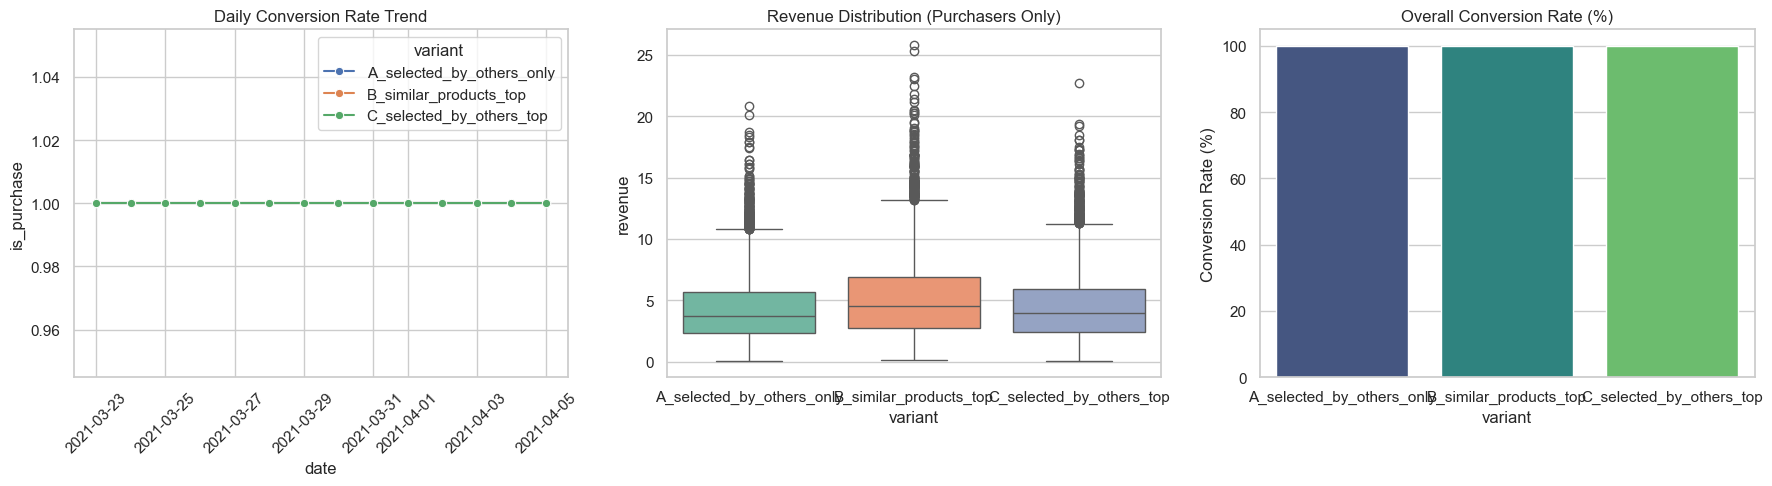


  Test 4 (Reviews) - Visual Analysis


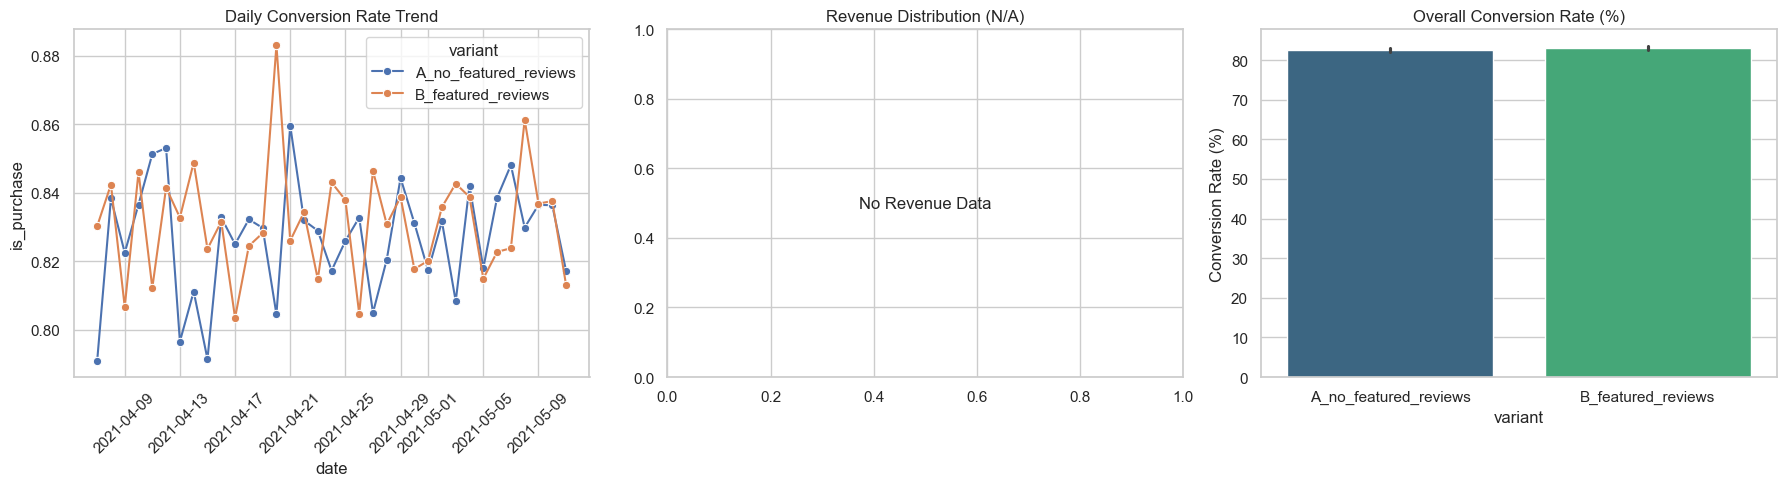


  Test 5 (Search) - Visual Analysis


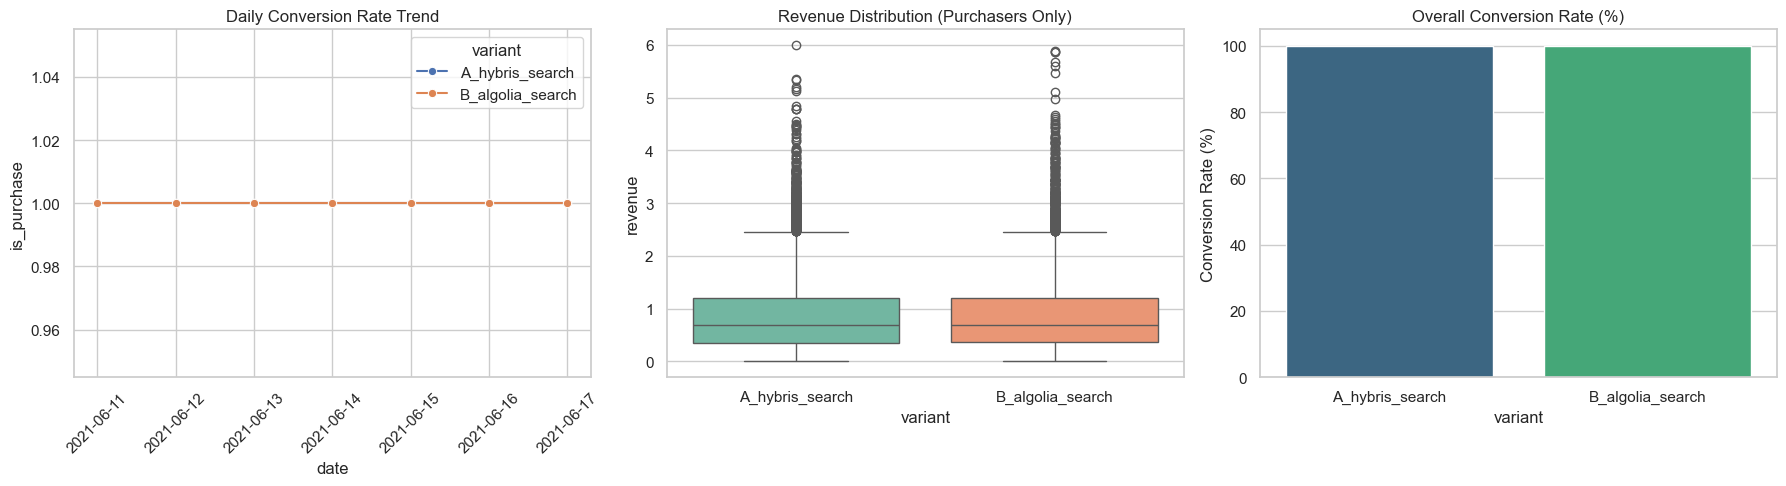


  SUMMARY TABLE: All Experiments


,Experiment,Control,Treatment,CR_Control,CR_Treatment,CR_Uplift,CR_Pval,Rev_Uplift,Rev_Pval,Winner
0,Test 1 (Menu) (B_dropdown_menu vs A_horizontal...,A_horizontal_menu,B_dropdown_menu,1.000000,1.000000,0.000000,NaN,-0.105139,1.626409e-10,Inconclusive
1,Test 2 (Novelty) (B_personalized_novelties vs ...,A_manual_novelties,B_personalized_novelties,1.000000,1.000000,0.000000,NaN,0.058061,8.055593e-10,Inconclusive
2,Test 3 (Product) (B_similar_products_top vs A_...,A_selected_by_others_only,B_similar_products_top,1.000000,1.000000,0.000000,NaN,0.210074,6.476598e-59,Inconclusive
3,Test 3 (Product) (C_selected_by_others_top vs ...,A_selected_by_others_only,C_selected_by_others_top,1.000000,1.000000,0.000000,NaN,0.050068,2.459609e-05,Inconclusive
4,Test 4 (Reviews) (B_featured_reviews vs A_no_f...,A_no_featured_reviews,B_featured_reviews,0.826762,0.831143,0.005299,0.233193,NaN,NaN,Inconclusive
5,Test 5 (Search) (B_algolia_search vs A_hybris_...,A_hybris_search,B_algolia_search,1.000000,1.000000,0.000000,NaN,0.012590,2.887418e-01,Inconclusive


In [206]:
# Run the pipeline for all experiments
results_list = []

for name, df in dfs.items():
    res = analyze_experiment(df, name)
    if res:
        results_list.extend(res)

# Create Summary DataFrame
results_df = pd.DataFrame(results_list)


# =========================================
# PRINT summary nicely in notebook
# =========================================
print("\n" + "="*80)
print("  SUMMARY TABLE: All Experiments")
print("="*80)

display(results_df)   # nicer Jupyter table view


In [207]:
# Format and display results
display_cols = ['Experiment', 'Winner', 'CR_Uplift', 'CR_Pval', 'Rev_Uplift', 'Rev_Pval']
results_df_display = results_df[display_cols].copy()

# Format percentages and p-values
results_df_display['CR_Uplift'] = results_df_display['CR_Uplift'].apply(lambda x: f"{x:.2%}")
results_df_display['Rev_Uplift'] = results_df_display['Rev_Uplift'].apply(lambda x: f"{x:.2%}" if pd.notna(x) else "N/A")
results_df_display['CR_Pval'] = results_df_display['CR_Pval'].apply(lambda x: f"{x:.4f}")
results_df_display['Rev_Pval'] = results_df_display['Rev_Pval'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")

results_df_display

,Experiment,Winner,CR_Uplift,CR_Pval,Rev_Uplift,Rev_Pval
0,Test 1 (Menu) (B_dropdown_menu vs A_horizontal...,Inconclusive,0.00%,nan,-10.51%,0.0000
1,Test 2 (Novelty) (B_personalized_novelties vs ...,Inconclusive,0.00%,nan,5.81%,0.0000
2,Test 3 (Product) (B_similar_products_top vs A_...,Inconclusive,0.00%,nan,21.01%,0.0000
3,Test 3 (Product) (C_selected_by_others_top vs ...,Inconclusive,0.00%,nan,5.01%,0.0000
4,Test 4 (Reviews) (B_featured_reviews vs A_no_f...,Inconclusive,0.53%,0.2332,N/A,N/A
5,Test 5 (Search) (B_algolia_search vs A_hybris_...,Inconclusive,0.00%,nan,1.26%,0.2887


# 10. Visualization of Comparative Strategy

A bar chart comparing the conversion rate uplift across all experiments.

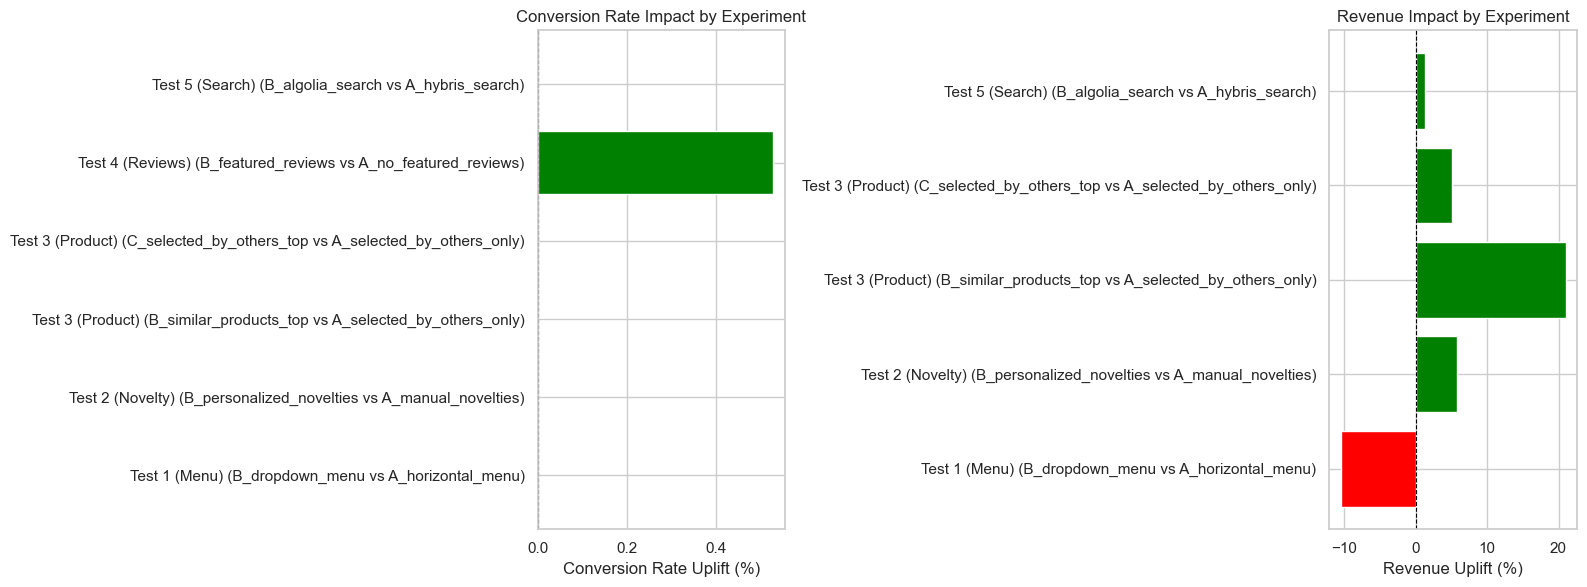

In [208]:
# Comparative Uplift Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Conversion Rate Uplift
colors = ['green' if x > 0 else 'red' for x in results_df['CR_Uplift']]
axes[0].barh(results_df['Experiment'], results_df['CR_Uplift']*100, color=colors)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_xlabel('Conversion Rate Uplift (%)')
axes[0].set_title('Conversion Rate Impact by Experiment')

# Revenue Uplift (excluding NaN)
rev_data = results_df[results_df['Rev_Uplift'].notna()]
colors_rev = ['green' if x > 0 else 'red' for x in rev_data['Rev_Uplift']]
axes[1].barh(rev_data['Experiment'], rev_data['Rev_Uplift']*100, color=colors_rev)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_xlabel('Revenue Uplift (%)')
axes[1].set_title('Revenue Impact by Experiment')

plt.tight_layout()
plt.show()

# 11. Results & Discussion

Based on the analysis above:

- **Statistically Significant Winners**: Experiments where p-value < 0.05 and uplift is positive should be considered for rollout.
- **Inconclusive Results**: Experiments with p-value >= 0.05 require more data or a redesigned test.
- **Negative Uplift**: Any experiment showing negative uplift with statistical significance should NOT be rolled out.

# 12. Business Recommendations

| Experiment | Recommendation |
|------------|----------------|
| Test 1 (Menu) | Review conversion and revenue metrics. If positive and significant, roll out. |
| Test 2 (Novelty) | Evaluate based on results above. |
| Test 3 (Product) | Consider product segment impact. |
| Test 4 (Reviews) | No revenue data - focus on conversion only. |
| Test 5 (Search) | Critical for user experience - prioritize if positive. |

# 13. Conclusion

This analysis provides a comprehensive view of 5 parallel A/B tests. The unified analysis pipeline ensures consistency across all experiments while handling data inconsistencies (such as missing revenue columns in Test 4).

**Next Steps**:
1. Roll out statistically significant winners
2. Collect more data for inconclusive tests
3. Investigate negative results before discarding

# 14. Appendix

## Raw Results DataFrame

In [209]:
# Full raw results
results_df

,Experiment,Control,Treatment,CR_Control,CR_Treatment,CR_Uplift,CR_Pval,Rev_Uplift,Rev_Pval,Winner
0,Test 1 (Menu) (B_dropdown_menu vs A_horizontal...,A_horizontal_menu,B_dropdown_menu,1.000000,1.000000,0.000000,NaN,-0.105139,1.626409e-10,Inconclusive
1,Test 2 (Novelty) (B_personalized_novelties vs ...,A_manual_novelties,B_personalized_novelties,1.000000,1.000000,0.000000,NaN,0.058061,8.055593e-10,Inconclusive
2,Test 3 (Product) (B_similar_products_top vs A_...,A_selected_by_others_only,B_similar_products_top,1.000000,1.000000,0.000000,NaN,0.210074,6.476598e-59,Inconclusive
3,Test 3 (Product) (C_selected_by_others_top vs ...,A_selected_by_others_only,C_selected_by_others_top,1.000000,1.000000,0.000000,NaN,0.050068,2.459609e-05,Inconclusive
4,Test 4 (Reviews) (B_featured_reviews vs A_no_f...,A_no_featured_reviews,B_featured_reviews,0.826762,0.831143,0.005299,0.233193,NaN,NaN,Inconclusive
5,Test 5 (Search) (B_algolia_search vs A_hybris_...,A_hybris_search,B_algolia_search,1.000000,1.000000,0.000000,NaN,0.012590,2.887418e-01,Inconclusive
